# Asset Price Valuation

## Executive Summary
In this study, I attempt to use the historical distribution of relative asset price ratio to assert whether an asset is currently underpriced or overpriced.

In [81]:
# Import libraries
import pandas as pd
import quandl
import math
import numpy as np
import scipy.stats
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import summary_table
from matplotlib import pyplot as plt
from scipy.stats import linregress
import os
%matplotlib notebook

# Set up folder directories
input_dir = "01_Raw_Data/"
procs_dir = "02_Processed_Data/"
output_dir = "03_Output_Data/"

In [3]:
start_date = "1900-01-01"
end_date = "2020-08-25"

### Prepare Price Data from Quandl
We are gonna leverage Quandl's free precious metal data for this analysis. Only run this module for periodic refresh as data are saved in the `\02_Processed_Data` folder.

#### Download Price for LBMA Gold
Uncomment the codes below to refresh the data.

In [14]:
# lbma_gold_df = quandl.get("LBMA/GOLD", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lbma_gold_df['LBMA_Gold_USD'] = (lbma_gold_df['USD (AM)'] + lbma_gold_df['USD (PM)']) *0.5
# lbma_gold_df.index = pd.to_datetime(lbma_gold_df.index)
# pd.DataFrame(lbma_gold_df['LBMA_Gold_USD']).to_csv(procs_dir + 'lbma_gold_usd.csv')

#### Download Price for LBMA Silver
Uncomment the codes below to refresh the data.

In [13]:
# lbma_silver_df = quandl.get("LBMA/SILVER", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lbma_silver_df.index = pd.to_datetime(lbma_silver_df.index)
# lbma_silver_df['LBMA_Silver_USD'] = lbma_silver_df['USD']
# pd.DataFrame(lbma_silver_df['LBMA_Silver_USD']).to_csv(procs_dir + 'lbma_silver_usd.csv')

#### Download Price for LPPM Platinum
Uncomment the codes below to refresh the data.

In [7]:
# lppm_plat_df = quandl.get("LPPM/PLAT", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lppm_plat_df.index = pd.to_datetime(lppm_plat_df.index)
# lppm_plat_df['LPPA_PLAT_USD'] = (lppm_plat_df['USD AM'] + lppm_plat_df['USD PM']) * 0.5
# pd.DataFrame(lppm_plat_df['LPPA_PLAT_USD']).to_csv(procs_dir + 'lppm_plat_usd.csv')

#### Download Price for LPPM Palladium
Uncomment the codes below to refresh the data.

In [8]:
# lppm_pall_df = quandl.get("LPPM/PALL", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lppm_pall_df.index = pd.to_datetime(lppm_pall_df.index)
# lppm_pall_df['LPPA_PALL_USD'] = (lppm_pall_df['USD AM'] + lppm_pall_df['USD PM']) * 0.5
# pd.DataFrame(lppm_pall_df['LPPA_PALL_USD']).to_csv(procs_dir + 'lppm_pall_usd.csv')

#### Append Asset Data

In [23]:
def read_price_df(df_dir):
    """Read asset data and resample to month-end.
    """
    output_df = pd.read_csv(df_dir, index_col=0, parse_dates=True)\
                  .resample('M').last().dropna()
    return(output_df)

def append_asset_df(df_list, df_name=None, dropna=False):
    """Merge all provided price dfs together, joining on the date index.
    """
    merge_df = pd.DataFrame()
    
    for df in df_list:
        merge_df = merge_df.merge(df, how='outer', left_index=True, right_index=True)
    
    if(dropna):
        merge_df = merge_df.dropna()
    
    if(df_name is not None):
        merge_df.columns = df_name
    
    return(merge_df)

In [24]:
# Read the downloaded data and resample to month-end
lbma_gold_usd = read_price_df(procs_dir + 'lbma_gold_usd.csv')
lbma_silver_usd = read_price_df(procs_dir + 'lbma_silver_usd.csv')
lppm_plat_usd = read_price_df(procs_dir + 'lppm_plat_usd.csv')
lppm_pall_usd = read_price_df(procs_dir + 'lppm_pall_usd.csv')

# Append read dataset
comb_df = append_asset_df([lbma_gold_usd, lbma_silver_usd, lppm_plat_usd, lppm_pall_usd],
                          df_name = ['Gold', 'Silver', 'Plat', 'Pall'], dropna=True)
comb_df.head()

,Gold,Silver,Plat,Pall
Date,,,,
1990-04-30,369.650,4.936,470.500,119.625
1990-05-31,363.375,5.070,491.375,119.525
1990-06-30,352.300,4.840,482.700,113.800
1990-07-31,371.700,4.855,480.375,116.625
1990-08-31,387.925,4.830,486.500,111.750


#### Calculate Price Ratio

In [54]:
def compute_price_ratio(price_df):
    """Compute the price ratio relative to the asset in the first column.
    """
    # Calculate ratio
    ratio_df = price_df.div(price_df.iloc[:, 0], axis=0)
    
    # Generate new column names so that ratios are properly identified
    base_asset = ratio_df.columns.values[0]
    rel_asset = [base_asset + "-to-" + colname for colname in ratio_df.columns.values[1:]]
    rel_asset.insert(0, base_asset)
    ratio_df.columns = rel_asset
    
    return(ratio_df)

In [57]:
ratio_df = compute_price_ratio(comb_df)
ratio_df.head()

,Gold,Gold-to-Silver,Gold-to-Plat,Gold-to-Pall
Date,,,,
1990-04-30,1.0,0.013353,1.272826,0.323617
1990-05-31,1.0,0.013953,1.352253,0.328930
1990-06-30,1.0,0.013738,1.370139,0.323020
1990-07-31,1.0,0.013062,1.292373,0.313761
1990-08-31,1.0,0.012451,1.254108,0.288071


### Plot Distribution

In [ ]:
# Find the median value so that they can be shifted

In [86]:
# fig, ax = plt.subplots(3, 1, sharey='row', figsize=(12,7))
# ax = ax.ravel() 
# this method helps you to go from a 2x3 array coordinates to 
# 1x6 array, it will be helpful to use as below



# Plot each asset side by side
# for idx in range(plot_df.shape[1]):
#     ax[idx] = sns.distplot(plot_df.iloc[:,idx])
    
# #     ax[idx].hist(plot_df.iloc[:,idx], density=True, bins=90, alpha=0.5)
#     ax[idx].set_ylabel(plot_df.columns[idx])

# ordered_days = plot_df
# g = sns.FacetGrid(plot_df, row_order=ordered_days)
# g.map(sns.distplot, "total_bill", hist=False, rug=True);

<IPython.core.display.Javascript object>


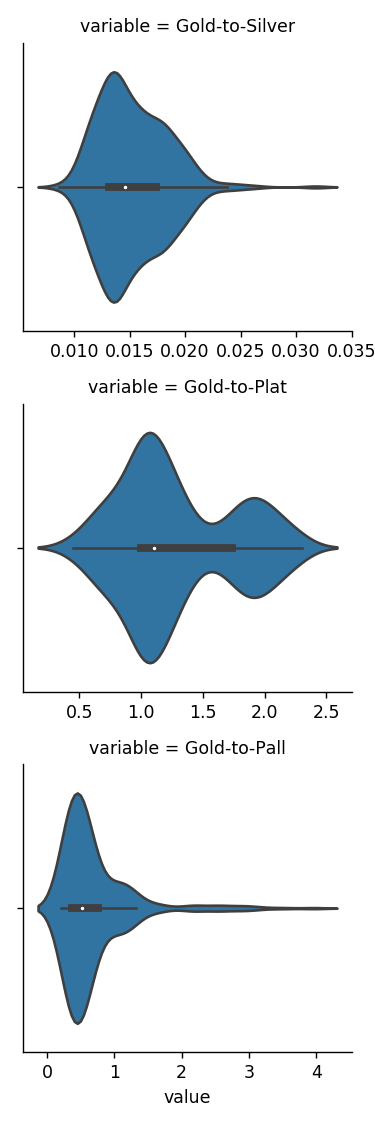

C:\Users\jiape\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [104]:
# Melt the dataframe
plot_df = pd.melt(ratio_df.iloc[:, 1:])

g = sns.FacetGrid(plot_df, row="variable", sharex=False, sharey=False)
g.map(sns.violinplot, "value", alpha=0.2, hist=True, rug=False);